In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew # for some statistics

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


In [3]:
# Save the "Id" column
train_ID = train["Id"]
test_ID = test["Id"]

# Now drop the "Id" colum since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# check again the data size after dropping the "Id" variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


## Processing outliers

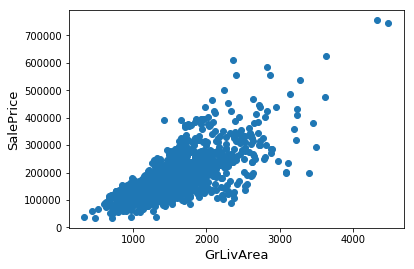

In [4]:
# Deleting outliers
train = train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train["GrLivArea"], train["SalePrice"])
plt.ylabel("SalePrice", fontsize=13)
plt.xlabel("GrLivArea", fontsize=13)
plt.show()

## Normality

因為要使用回歸相關模型，所以要先確認一些假設是否符合

1.Target variable is right skewed.

2.Need to transform this variable and make it more normally distributed.

3.Log-transformation of the target variable


 mu = 180932.92 and sigma = 79467.79



c:\users\user\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'SalePrice distribution')

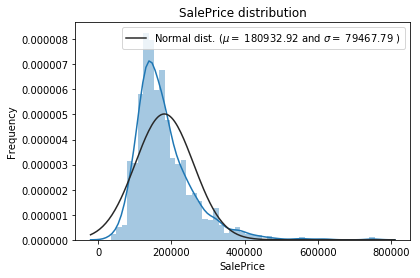

In [5]:
sns.distplot(train["SalePrice"] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train["SalePrice"])
print( "\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

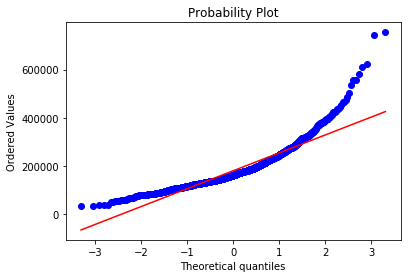

In [6]:
# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train["SalePrice"], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



c:\users\user\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'SalePrice distribution')

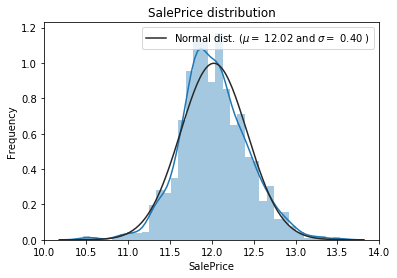

In [7]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Check the new distribution 
sns.distplot(train["SalePrice"] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train["SalePrice"])
print( "\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

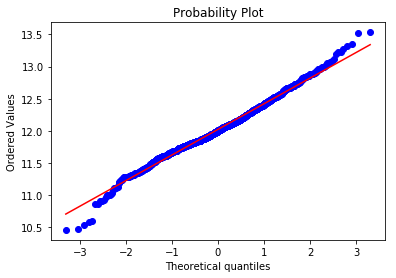

In [8]:
# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train["SalePrice"], plot=plt)
plt.show()

## Features engineering

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(["SalePrice"], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


- PoolQC 由於大部分房子都沒有游泳池，所以缺失值全部補上字串 None

In [10]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- MiscFeature 目前沒有想法怎麼處理，不排除刪掉

In [11]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- Alley 目前沒有想法怎麼處理，不排除刪掉

In [12]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- Fence 目前沒有想法怎麼處理，不排除刪掉

In [13]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- FireplaceQu 目前沒有想法怎麼處理，不排除刪掉

In [14]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- LotFrontage 由於每個地區距離街道應該會相似，所以利用相同變數 Neighborhood 的 LotFrontage 中位數來填補缺失值

In [15]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- GarageXXX 數值的欄位缺失值補 0，字串的欄位缺失值補 "None"

In [16]:
for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
    all_data[col] = all_data[col].fillna("None")

In [17]:
for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
    all_data[col] = all_data[col].fillna(0)

- BsmtFinXXX 做法跟 Garage 一樣

In [18]:
for col in ("BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF","TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)

In [19]:
for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
    all_data[col] = all_data[col].fillna("None")

- MasVnrType、MasVnrArea 目前沒有想法怎麼處理，不排除刪掉

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- Electrical 電子系統的等級

In [21]:
all_data["Electrical"] = all_data["Electrical"].fillna(all_data["Electrical"].mode()[0])

- MSZoning 房屋所在地的種類。工業、農地之類的。

In [22]:
all_data["MSZoning"] = all_data["MSZoning"].fillna(all_data["MSZoning"].mode()[0])

- Utilities 擁有的能源，瓦斯、水之類的。train 有一個 NoSeWa、test 有兩個 NA，其餘都是 AllPub。所以這變數好像沒啥用。

In [23]:
all_data = all_data.drop(["Utilities"], axis=1)

- Functional 感覺有點像是房屋是否有被法院保管或負載之類的

In [24]:
all_data["Functional"] = all_data["Functional"].fillna(all_data["Functional"].mode()[0])

- Exterior1st、Exterior2nd test 各有一個缺失值。其中一個類別特別多數量所以選擇利用該類別來回填缺失值

In [25]:
all_data["Exterior1st"] = all_data["Exterior1st"].fillna(all_data["Exterior1st"].mode()[0])
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna(all_data["Exterior2nd"].mode()[0])

- SaleType test 有一個缺失值

In [26]:
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])

- KitchenQual test 有一個缺失值

In [27]:
all_data["KitchenQual"] = all_data["KitchenQual"].fillna(all_data["KitchenQual"].mode()[0])

In [28]:
# Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing Ratio" :all_data_na})
missing_data.head()

,Missing Ratio


## 調整數值變數中的類別變數

In [29]:
# MSSubClass
all_data["MSSubClass"] = all_data["MSSubClass"].apply(str)

# OverallQual、OverallCond
all_data["OverallQual"] = all_data["OverallQual"].apply(str)
all_data["OverallCond"] = all_data["OverallCond"].apply(str)

# YearBuilt YearRemodAdd

# YrSold、MoSold
all_data["YrSold"] = all_data["YrSold"].apply(str)
all_data["MoSold"] = all_data["MoSold"].apply(str)

In [158]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 78 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            2917 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2917 non-null object
BsmtExposure     2917 non-null object
BsmtFinSF1       2917 non-null float64
BsmtFinSF2       2917 non-null float64
BsmtFinType1     2917 non-null object
BsmtFinType2     2917 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2917 non-null object
BsmtUnfSF        2917 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2917 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      29

- 透過 Label Encoder 將一些有好壞順序的類別變數轉換成數字

In [30]:
from sklearn.preprocessing import LabelEncoder

cols = ("MSSubClass", "Street", "Alley", "LotShape", "LandSlope", "OverallQual", "OverallCond",
        "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure","BsmtFinType1", 
        "BsmtFinType2", "HeatingQC", "CentralAir", "KitchenQual", "Functional", "FireplaceQu",
        "GarageQual", "GarageCond", "GarageFinish", "PavedDrive", "PoolQC", "Fence", "YrSold", "MoSold")

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print("Shape all_data: {}".format(all_data.shape))

Shape all_data: (2917, 78)


- 新增加一個變數 TotalSF

In [31]:
# Adding total sqfootage feature 
all_data["TotalSF"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"]

In [32]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({"Skew" :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [33]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [34]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [35]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modeling

In [36]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import clone, BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [37]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=16).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Single Model

In [38]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [39]:
KRR = KernelRidge(alpha=0.6, kernel="polynomial", degree=2, coef0=2.5)

In [40]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [41]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [42]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1157 (0.0070)



In [43]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1197 (0.0069)



In [44]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1192 (0.0086)



In [45]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1157 (0.0070)



### Average single model

In [59]:
class AveragingModels(BaseEstimator):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(m) for m in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [60]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1120 (0.0072)



### Stacking Model

In [79]:
class StackingModels(BaseEstimator):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.base_models_ = [[] for m in self.base_models] # len(base_models) * n_folds
        print("base_models_ shape:{}".format(np.array(self.base_models_).shape))
        
        self.meta_model_ = clone(self.meta_model)
        print("meta_model_ shape:{}".format(np.array(self.meta_model_).shape))
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=16)
        
        oof_predictions = np.zeros((X.shape[0], len(self.base_models_)))
        print("oof_predictions shape{}".format(oof_predictions.shape))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                oof_predictions[holdout_index, i] = y_pred
        
        self.meta_model_.fit(oof_predictions, y)
        return

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [80]:
stack_models = StackingModels(base_models=(ENet,GBoost,KRR), meta_model=lasso)
score = rmsle_cv(stack_models)
print("Stacking models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

base_models_ shape:(3, 0)
meta_model_ shape:()
oof_predictions shape(1166, 3)
base_models_ shape:(3, 0)
meta_model_ shape:()
oof_predictions shape(1166, 3)
base_models_ shape:(3, 0)
meta_model_ shape:()
oof_predictions shape(1166, 3)
base_models_ shape:(3, 0)
meta_model_ shape:()
oof_predictions shape(1167, 3)
base_models_ shape:(3, 0)
meta_model_ shape:()
oof_predictions shape(1167, 3)
Stacking models score: 0.1105 (0.0067)


## Submission

In [56]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [61]:
averaged_models.fit(train.values, y_train)
avg_model_train_pre = averaged_models.predict(train.values)
avg_model_pre = averaged_models.predict(test.values)
avg_model_pre = np.expm1(avg_model_pre)
print(rmsle(y_train, avg_model_train_pre))

0.0815532712946927


In [82]:
stack_models.fit(train.values, y_train)
print("start predict(train)")
stack_model_train_pre = stack_models.predict(train.values)
print(rmsle(y_train, stack_model_train_pre))
print("start predict(test)")
stack_model_pre = stack_models.predict(test.values)
stack_model_pre = np.expm1(stack_model_pre)

base_models_ shape:(3, 0)
meta_model_ shape:()
oof_predictions shape(1458, 3)
start predict(train)
0.07636323108645247
start predict(test)


In [83]:
sub = pd.DataFrame()
sub["Id"] = test_ID
sub["SalePrice"] = stack_model_pre
sub.to_csv("data/submission.csv",index=False)